In [2]:
%load_ext autoreload
%autoreload 2
#______________________________________________________________________________
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import _pickle as pkl
from shap_utils import *
from DistShap import DistShap
from Shapley import ShapNN
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load (and if necessary download) CoverType dataset

In [3]:
from sklearn.datasets import fetch_covtype
data, target = fetch_covtype(return_X_y=True)

We compute $D$-Shapley and TMC-Shapley values for 200 data points. For $D$-Shapley we fix $m=200$.

In [4]:
model_family = 'logistic'
train_size = 200
m = 200
alpha = None # Weighted sampling parameter
num_test = 5000
test_size = 1000
heldout_size = 1000
directory = './temp/covertype'
np.random.seed(0)
idxs = np.random.permutation(len(data))
data, target = data[idxs], target[idxs] - 1
X_train, y_train = data[:train_size], target[:train_size]
X_dist, y_dist = data[train_size:-(test_size+heldout_size)], target[train_size:-(test_size+heldout_size)]
X_test, y_test = data[-(test_size+heldout_size):], target[-(test_size+heldout_size):]
normalizer_fn = lambda X: (X - np.mean(X_dist, 0)) / np.clip(np.std(X_dist, 0), 1e-12, None)
X_train, X_dist, X_test = normalizer_fn(X_train), normalizer_fn(X_dist), normalizer_fn(X_test)

Defining the Dist-Shapley module.

In [5]:
overwrite = False #If True, will remove old results.
dshap = DistShap(X=X_train, y=y_train,
                 X_test=X_test, y_test=y_test, num_test=test_size,
                 X_tot=X_dist, y_tot=y_dist,
                 sources=None,
                 sample_weight=None,
                 model_family=model_family,
                 metric='accuracy',
                 overwrite=overwrite,
                 directory=directory)

000000


Run iterations of both algorithms. The following step can run in parallel as iterations of both algorithms are independent (This will take a while to converge).

In [6]:
dshap.run(tmc_run=True, dist_run=True, truncation=m, alpha=alpha, save_every=10, err=0.01)

1 out of 10 Dist_Shapley iterations.
2 out of 10 Dist_Shapley iterations.
3 out of 10 Dist_Shapley iterations.
4 out of 10 Dist_Shapley iterations.
5 out of 10 Dist_Shapley iterations.
6 out of 10 Dist_Shapley iterations.
7 out of 10 Dist_Shapley iterations.
8 out of 10 Dist_Shapley iterations.
9 out of 10 Dist_Shapley iterations.
10 out of 10 Dist_Shapley iterations.
1 out of 10 TMC_Shapley iterations.
Truncated at 118
2 out of 10 TMC_Shapley iterations.
Truncated at 87
3 out of 10 TMC_Shapley iterations.
Truncated at 151
4 out of 10 TMC_Shapley iterations.
Truncated at 187
5 out of 10 TMC_Shapley iterations.
Truncated at 196
6 out of 10 TMC_Shapley iterations.
7 out of 10 TMC_Shapley iterations.
Truncated at 185
8 out of 10 TMC_Shapley iterations.
9 out of 10 TMC_Shapley iterations.
Truncated at 167
10 out of 10 TMC_Shapley iterations.
Truncated at 155
1 out of 10 Dist_Shapley iterations.
2 out of 10 Dist_Shapley iterations.
3 out of 10 Dist_Shapley iterations.
4 out of 10 Dist_Shapl

Load current and previously saved results.

In [14]:
dshap.load_results(verbose=False)
vals_tmc = np.mean(dshap.results['mem_tmc'], 0)
if alpha is None:
    vals_dist = np.mean(dshap.results['mem_dist'], 0)
else:
    sizes = np.array([len(i) for i in dshap.results['idxs_dist']])
    ps = np.expand_dims(1/(sizes ** alpha), -1) / np.sum(1 / (np.arange(1, m + 1) ** alpha))
    vals_dist = np.mean(dshap.results['mem_dist'] / (ps * m), 0)

Let's examine the case study mentioned in section 4. Let's have a buyer with 100 points who gets another 100 points (in total 200 points). We compute data Shapley values of the buyer and distributional Shapley values of the seller. Plot performance plots for point removal experiment. (Note that we can divide the computed dataset for which we computed distributional Shapley values in half and act as if the second half was acquired.)

In [15]:
X_new, y_new = dshap.X[100:], dshap.y[100:]
vals_tmc_new, vals_dist_new = vals_tmc[100:], vals_dist[100:]
X_init, y_init = dshap.X[:100], dshap.y[:100]
print('Rank correlation of data shapley vs distributional shapley values = {0:.3f}'.format(
    spearmanr(vals_tmc_new, vals_dist_new)[0]))
print('Absoulte percentage error of overal data shapley vs distributional shapley value = {0:.1f}%'.format(
    100 * np.abs(np.sum(vals_tmc_new) - np.sum(vals_dist_new)) / np.sum(vals_tmc_new)))

Rank correlation of data shapley vs distributional shapley values = 0.564
Absoulte percentage error of overal data shapley vs distributional shapley value = 4.4%


In [16]:
performance_points = np.arange(0, len(X_new)+1, len(X_new)//20)
perf_func = lambda order: portion_performance(
        dshap, order, performance_points,
        X_new, y_new, X_init, y_init, dshap.X_heldout, dshap.y_heldout)

In [17]:
performance_points = np.arange(0, len(X_new)//2, len(X_new)//40)
d_perf_inc = perf_func(np.argsort(-vals_dist_new))
tmc_perf_inc = perf_func(np.argsort(-vals_tmc_new))
rnd_perf_inc = np.mean([perf_func(np.random.permutation(len(X_new))) for _ in range(5)], 0)

Text(0.5, 1.0, 'Removing low value points')

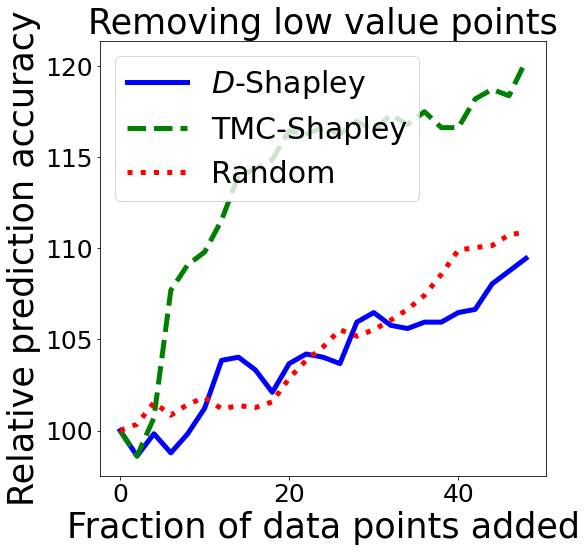

In [18]:
plt.rcParams['font.size'] = 25
fig = plt.figure(figsize=(8, 8))
plt.plot(performance_points / len(X_new) * 100, d_perf_inc / d_perf_inc[0] * 100,
         linestyle='solid', c='b', lw=5)
plt.plot(performance_points / len(X_new) * 100, tmc_perf_inc / tmc_perf_inc[0] * 100,
         linestyle='dashed', c='g', lw=5)
plt.plot(performance_points / len(X_new) * 100, rnd_perf_inc / rnd_perf_inc[0] * 100,
         linestyle='dotted', c='r', lw=5)
plt.xlabel('Fraction of data points added', fontsize=35)
plt.ylabel('Relative prediction accuracy', fontsize=35)
plt.legend(['$D$-Shapley', 'TMC-Shapley', 'Random'], fontsize=30)
plt.title('Removing low value points', fontsize=35)

We can do the same thing but in reverse direction (removing low value points)

In [12]:
performance_points = np.arange(0, len(X_new)//2, len(X_new)//40)
d_perf_dec = perf_func(np.argsort(vals_dist_new))
tmc_perf_dec = perf_func(np.argsort(vals_tmc_new))
rnd_perf_dec = np.mean([perf_func(np.random.permutation(len(X_new))) for _ in range(5)], 0)

Text(0.5, 1.0, 'Removing low value points')

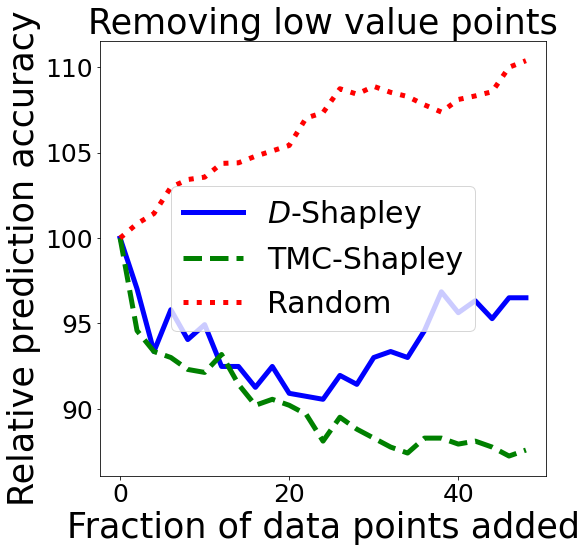

In [13]:
plt.rcParams['font.size'] = 25
fig = plt.figure(figsize=(8, 8))
plt.plot(performance_points / len(X_new) * 100, d_perf_dec / d_perf_dec[0] * 100,
         linestyle='solid', c='b', lw=5)
plt.plot(performance_points / len(X_new) * 100, tmc_perf_dec / tmc_perf_dec[0] * 100,
         linestyle='dashed', c='g', lw=5)
plt.plot(performance_points / len(X_new) * 100, rnd_perf_dec / rnd_perf_dec[0] * 100,
         linestyle='dotted', c='r', lw=5)
plt.xlabel('Fraction of data points added', fontsize=35)
plt.ylabel('Relative prediction accuracy', fontsize=35)
plt.legend(['$D$-Shapley', 'TMC-Shapley', 'Random'], fontsize=30)
plt.title('Removing low value points', fontsize=35)